In [1]:
import os
import cv2
import numpy as np
import warnings
import subprocess
from natsort import natsorted
import random
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

os.chdir('..')
os.getcwd()

'/home/soham/Desktop/GitHub/Posture-Detection-in-Videos'

In [2]:
class LucasKanadePositionDetector:
    '''
    Class to process a video and detect positions using Lucas-Kanade Optical Flow.

    Args:
        video_path (str): Path to the input video file.
        output_dir (str): Directory to save the processed frames.
        max_corners (int): Maximum number of corners to return. Default is 100.
        quality_level (float): Quality level for corner detection. Default is 0.3.
        min_distance (int): Minimum distance between detected corners. Default is 7.
        block_size (int): Size of the averaging block for corner detection. Default is 7.
        win_size (tuple): Size of the search window for optical flow. Default is (15, 15).
        max_level (int): Maximum number of pyramid levels for optical flow. Default is 2.
        criteria (tuple): Criteria for termination of the iterative search. Default is (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03).

    Methods:
        detect(): Processes the video frame by frame, detecting positions and saving frames.
    
    Returns:
        Images with detected positions are saved in the specified output directory.
    '''

    def __init__(self, video_path, output_dir, max_corners=100, quality_level=0.3,
                 min_distance=7, block_size=7, win_size=(15, 15), max_level=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)):
        
        self.video_path = video_path
        self.output_dir = output_dir# ➕ Draw lines between all detected new points

        self.feature_params = dict(maxCorners=max_corners, qualityLevel=quality_level,
                                   minDistance=min_distance, blockSize=block_size)
        self.lk_params = dict(winSize=win_size, maxLevel=max_level, criteria=criteria)

    def detect(self):
        cap = cv2.VideoCapture(self.video_path)
        ret, old_frame = cap.read()

        if not ret:
            print(f"[Error] Could not read the video: {self.video_path}")
            cap.release()
            return

        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **self.feature_params)

        frame_id = 0

        while True:
            frame_id += 1
            ret, frame = cap.read()
            if not ret:
                break

            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            if p0 is not None and len(p0) > 0:
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)

                if p1 is not None and st is not None:
                    good_new = p1[st == 1]
                    good_old = p0[st == 1]

                    for new, old in zip(good_new, good_old):
                        a, b = new.ravel()
                        c, d = old.ravel()
                        cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                        cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

                    # ➕ Draw lines between all detected new points
                    # for i in range(len(good_new)):
                    #     for j in range(i + 1, len(good_new)):
                    #         pt1 = tuple(good_new[i].ravel().astype(int))
                    #         pt2 = tuple(good_new[j].ravel().astype(int))
                    #         cv2.line(frame, pt1, pt2, (255, 0, 0), 1)

                    p0 = good_new.reshape(-1, 1, 2)
                else:
                    p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **self.feature_params)
            else:
                p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **self.feature_params)

            cv2.imwrite(os.path.join(self.output_dir, f'frame_{frame_id}.jpg'), frame)

            if cv2.waitKey(30) & 0xFF == 27:
                break

            old_gray = frame_gray.copy()

        cap.release()
        cv2.destroyAllWindows()
        print(f"Processed video saved to: {self.output_dir}")



In [3]:

class VideoCreator:
    '''
    Class to create a video from a series of image frames.

    Args:
        frame_dir (str): Directory containing the image frames.
        output_path (str): Path to save the output video. Default is "output/video_output.mp4".
        fps (int): Frames per second for the output video. Default is 30.

    Methods:
        _load_frames(): Loads image frames from the specified directory.
        _get_frame_size(): Gets the size of the first frame to set video dimensions.
        create_video(): Creates a video from the loaded frames and saves it to the specified output path.

    Returns:
        A video file created from the image frames is saved to the specified output path.
    '''

    def __init__(self, frame_dir, output_path="output/output_video.mp4", fps=30):
        self.frame_dir = frame_dir
        self.output_path = output_path
        self.fps = fps
        self.frames = self._load_frames()

        if not self.frames:
            raise ValueError(f"No frames found in directory: {frame_dir}")

        self.frame_size = self._get_frame_size(self.frames[0])
        self.fourcc = self._choose_fourcc()


    def _load_frames(self):
        valid_exts = ('.jpg', '.jpeg', '.png')
        return natsorted([f for f in os.listdir(self.frame_dir) if f.lower().endswith(valid_exts)])


    def _get_frame_size(self, sample_file):
        path = os.path.join(self.frame_dir, sample_file)
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Can't read sample frame: {sample_file}")
        return (img.shape[1], img.shape[0])


    def _choose_fourcc(self):
        ext = os.path.splitext(self.output_path)[-1].lower()
        if ext == ".avi":
            return cv2.VideoWriter_fourcc(*"XVID")
        else:  # .mp4 or others
            return cv2.VideoWriter_fourcc(*"mp4v")


    def create_video(self):
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        writer = cv2.VideoWriter(self.output_path, self.fourcc, self.fps, self.frame_size)

        for f in self.frames:
            img = cv2.imread(os.path.join(self.frame_dir, f))
            if img is None:
                print(f"Skipping unreadable frame: {f}")
                continue
            if (img.shape[1], img.shape[0]) != self.frame_size:
                img = cv2.resize(img, self.frame_size)
            writer.write(img)

        writer.release()
        return self.output_path




def convert_to_modern_mp4(input_path, output_path):
    cmd = [
        "ffmpeg",
        "-y",
        "-i", input_path,
        "-c:v", "libx264",
        "-preset", "fast",
        "-crf", "23",
        "-c:a", "aac",
        "-b:a", "128k",
        output_path
    ]
    subprocess.run(cmd, check=True)
    print(f"Video successfully saved to: {output_path}")
    os.remove(input_path)


# Example 1

In [4]:
video_name = "demo1"
video_path = f"data/{video_name}.mp4"
frame_dir = f"frames/lucas_kanade/{video_name}/"

lk_detector = LucasKanadePositionDetector(video_path, frame_dir)
lk_detector.detect()


frame_dir = f"frames/lucas_kanade/{video_name}/"
vc = VideoCreator(frame_dir, output_path=f"output/{video_name}_output_lucas_kanade.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{video_name}_output_lucas_kanade.mp4")


Processed video saved to: frames/lucas_kanade/demo1/


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo1_output_lucas_kanade.mp4


frame=  164 fps=0.0 q=-1.0 Lsize=     636kB time=00:00:05.36 bitrate= 971.0kbits/s speed= 5.7x    
video:634kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.363785%
[libx264 @ 0x59f18e414440] frame I:3     Avg QP:15.39  size: 22204
[libx264 @ 0x59f18e414440] frame P:93    Avg QP:21.22  size:  5095
[libx264 @ 0x59f18e414440] frame B:68    Avg QP:21.59  size:  1587
[libx264 @ 0x59f18e414440] consecutive B-frames: 40.9%  8.5%  9.1% 41.5%
[libx264 @ 0x59f18e414440] mb I  I16..4: 39.0% 57.4%  3.6%
[libx264 @ 0x59f18e414440] mb P  I16..4:  1.2%  5.5%  0.2%  P16..4: 16.9%  4.0%  1.9%  0.0%  0.0%    skip:70.2%
[libx264 @ 0x59f18e414440] mb B  I16..4:  0.6%  1.8%  0.1%  B16..8: 11.0%  1.2%  0.1%  direct: 1.5%  skip:83.8%  L0:58.1% L1:36.8% BI: 5.1%
[libx264 @ 0x59f18e414440] 8x8 transform intra:72.8% inter:79.8%
[libx264 @ 0x59f18e414440] coded y,uvDC,uvAC intra: 38.0% 41.4% 5.2% inter: 4.3% 4.2% 0.2%
[libx264 @ 0x59f18e414440] i16 v,h,dc,p: 42% 38% 13%  7%
[lib

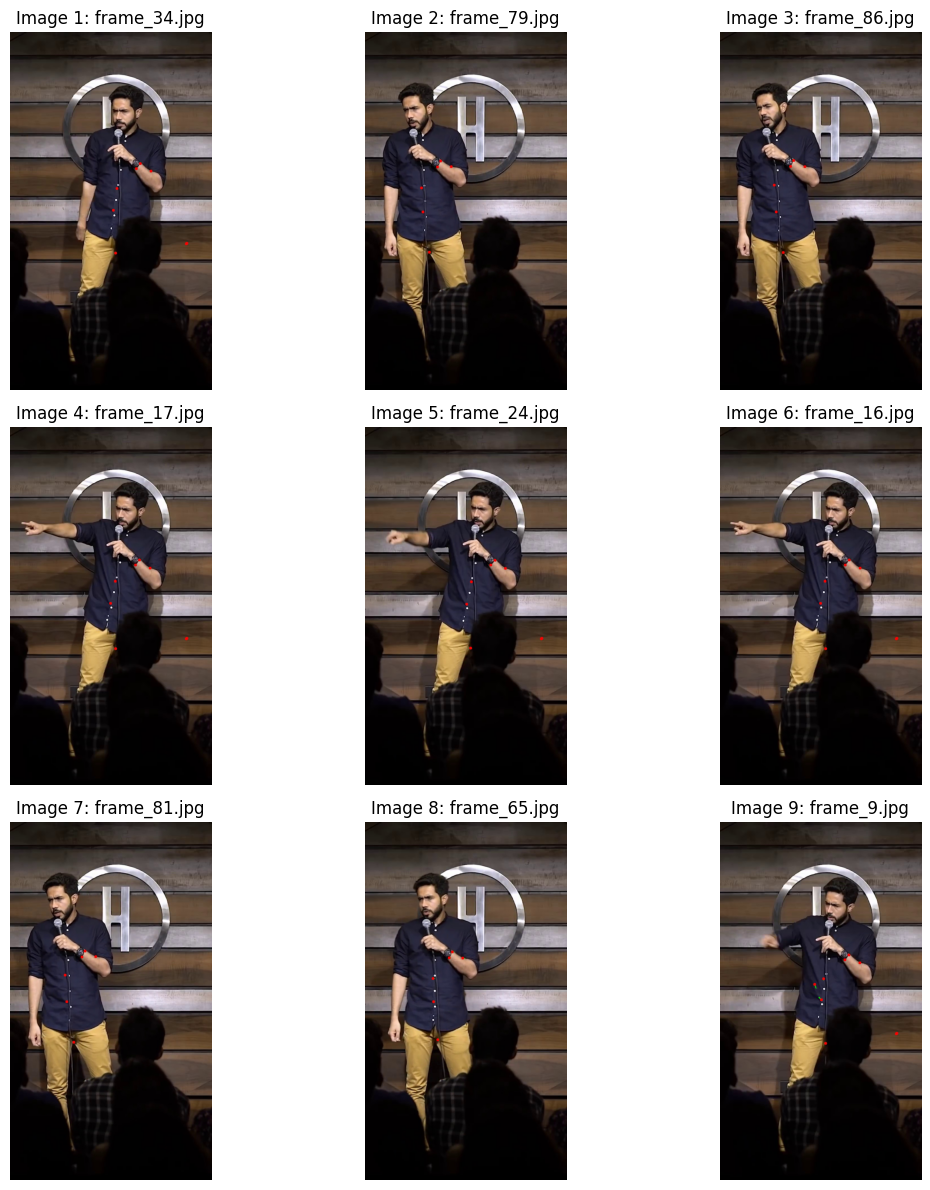

In [5]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) < 100]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Example 2

In [6]:
video_name = "demo2"
video_path = f"data/{video_name}.mp4"
frame_dir = f"frames/lucas_kanade/{video_name}/"

lk_detector = LucasKanadePositionDetector(video_path, frame_dir)
lk_detector.detect()


frame_dir = f"frames/lucas_kanade/{video_name}/"
vc = VideoCreator(frame_dir, output_path=f"output/{video_name}_output_lucas_kanade.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{video_name}_output_lucas_kanade.mp4")


Processed video saved to: frames/lucas_kanade/demo2/


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo2_output_lucas_kanade.mp4


frame=  538 fps=520 q=-1.0 Lsize=    1724kB time=00:00:17.83 bitrate= 792.0kbits/s speed=17.2x    
video:1717kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.394691%
[libx264 @ 0x56f30fba4480] frame I:3     Avg QP:19.78  size: 19895
[libx264 @ 0x56f30fba4480] frame P:198   Avg QP:22.18  size:  5763
[libx264 @ 0x56f30fba4480] frame B:337   Avg QP:25.45  size:  1653
[libx264 @ 0x56f30fba4480] consecutive B-frames: 13.2%  7.4%  7.2% 72.1%
[libx264 @ 0x56f30fba4480] mb I  I16..4: 23.8% 58.7% 17.5%
[libx264 @ 0x56f30fba4480] mb P  I16..4:  2.7%  5.8%  0.8%  P16..4: 44.1% 13.5%  7.5%  0.0%  0.0%    skip:25.6%
[libx264 @ 0x56f30fba4480] mb B  I16..4:  1.2%  3.5%  0.1%  B16..8: 28.7%  7.2%  1.0%  direct: 6.4%  skip:52.0%  L0:49.1% L1:41.3% BI: 9.6%
[libx264 @ 0x56f30fba4480] 8x8 transform intra:66.2% inter:57.8%
[libx264 @ 0x56f30fba4480] coded y,uvDC,uvAC intra: 45.1% 69.9% 19.4% inter: 11.0% 18.5% 2.3%
[libx264 @ 0x56f30fba4480] i16 v,h,dc,p: 18% 56% 19%  7%


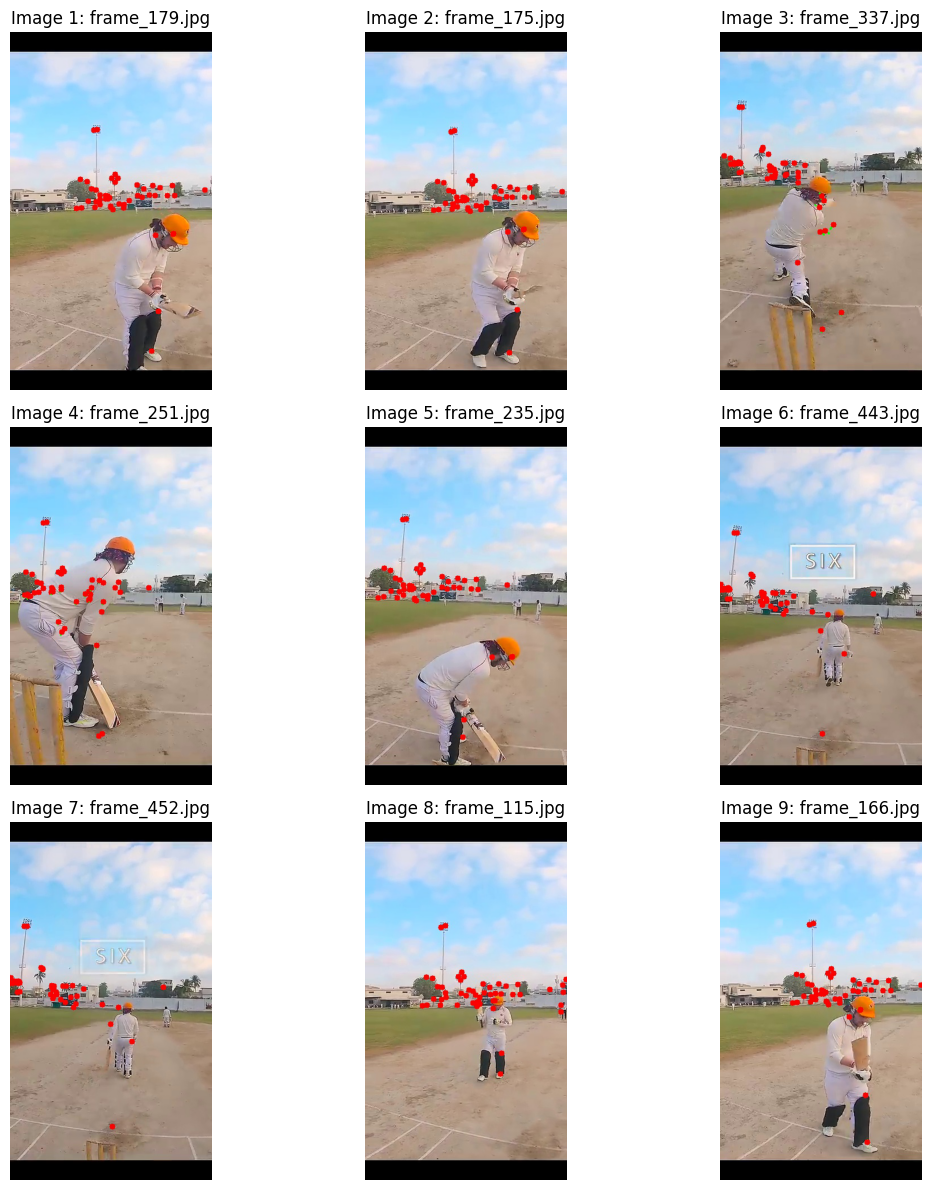

In [7]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) > 100 and int(f.split('_')[1].split('.')[0])]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()